# Notebook for processing openAF data with SLD or laser diode

Assumption is that there is only XYZ data, no T or C

In [86]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
from aicsimageio import AICSImage as imio
from alive_progress import alive_bar
import cv2

In [87]:
#sourcepath = "/Users/sh2717/Documents/AutoFocus_NNN/Data/openFrame/20231023_2inch_60um_1um_3ms/stack/stack_MMStack_Default.ome.tif"
sourcepath = "C:\\Temp\\Testdata\\AF\\2.5inch_LaserDiode\\20231023_2.5inch_50um_1um_2ms\\stack\\stack_MMStack_Default.ome.tif"

In [96]:
class data_source():
    def __init__(self):
        self.datavol = None
        self.plainvol = None
        self.blurvol = None
        self.bgsubvol = None
        self.filtvol = None
        self.name = None
        self.sourcepath = None
        self.metricnames = None
        self.metricvals = None
        self.effects = None
        self.gblur_applied = 0
        self.thresh = 0


        self.plainvol_mpx = None #mp=mean proj
        self.plainvol_mpy = None
        self.bgsubvol_mpx = None
        self.bgsubvol_mpy = None
        self.filtvol_mpy= None
        self.filtvol_mpx = None
        
    # Remember default TCZYX 
    
    def load(self, sourcepath):
        self.datavol = imio(sourcepath)
        self.sourcepath = sourcepath
        self.plainvol = np.asarray(np.squeeze(self.datavol.data.copy()),dtype=np.int64) #(51, 1536, 2048)
        self.blurvol = np.asarray(np.squeeze(self.datavol.data.copy()),dtype=np.int64)
        self.bgsubvol = np.asarray(np.squeeze(self.datavol.data.copy()),dtype=np.int64)
        self.filtvol = np.asarray(np.squeeze(self.datavol.data.copy()),dtype=np.int64)
        print(str(self.datavol.dims) + " loaded from " + sourcepath)

    def label(self, name_in):
        self.name = name_in
    
    def plain_mpx(self):
        self.plainvol_mpx = np.mean(self.blurvol, axis=1)
        return self.plainvol_mpx    
    def plain_mpy(self):    
        self.plainvol_mpy = np.mean(self.blurvol, axis=2)
        return self.plainvol_mpy
    def bgsub_mpx(self):    
        self.bgsubvol_mpx = np.mean(self.bgsubvol, axis=1)
        return self.bgsubvol_mpx # ,self.bgsubvol_mpx.shape  (51, 2048)     
    def bgsub_mpy(self):
        self.bgsubvol_mpy = np.mean(self.bgsubvol, axis=2)
        return self.bgsubvol_mpy
    def filtvol_xy(self):
        self.filtvol_mpx = np.asarray(np.zeros((51, 2048)))
        self.filtvol_mpy = np.asarray(np.zeros((51, 1536)))
        print('self.filtvol_mpx, self.filtvol_mpy')
    
    def XZ_sec(self, Yplane):
        return np.squeeze(LDstack.datavol.get_image_data("ZXCT",Y=Yplane))

    def YZ_sec(self, Xplane):
        return np.squeeze(LDstack.datavol.get_image_data("ZYCT",X=Xplane))

    def get_squeezed(self):
        return self.plainvol
    
    def XY_Z(self, Zplane):
        return np.squeeze(self.plainvol[Zplane])
    
    def XY_Z_bgsub(self, Zplane):
        return np.squeeze(self.filtvol[Zplane])
    
    def XY_Z_filt_bgsub(self, Zplane):
        return np.squeeze(self.filtvol[Zplane])#-self.bgsubvol[Zplane])
    
    #Z=0, Y=1, X=2
    def get_maxproj(self, dim):
        return np.max(self.plainvol,dim)

    def get_meanproj(self, dim):
        return np.mean(self.plainvol,dim) # for dim=0,1,2: (1536, 2048) (51, 2048) (51, 1536)

    def get_minproj(self, dim):
        return np.min(self.plainvol,dim)

    def get_blur_maxproj(self, Zplane,dim):
        return np.max(self.blurvol[Zplane],dim)

    def get_blur_meanproj(self, Zplane,dim):
        return np.mean(self.blurvol[Zplane],dim)

    def get_blur_minproj(self, dim):
        return np.min(self.blurvol,dim)    

    def get_bgsub_maxproj(self, Zplane,dim):
        return np.max(self.bgsubvol[Zplane],dim)
    def get_bgsub_maxproj_2d(self, Zplane):
        return np.max(self.bgsubvol[Zplane])
    def plot_bgsub_maxproj_2d(self):
        Zplane_x=np.arange((-self.bgsubvol.shape[0]+1)/2,(self.bgsubvol.shape[0]-1)/2+1,1)
        Zplane=np.arange(0,self.bgsubvol.shape[0],1)
        maxL=[]
        for i in Zplane:
            maxL.append(self.get_bgsub_maxproj_2d(i))
        plt.plot(Zplane_x,maxL)
        plt.title('max value per z plane')
        plt.show() 

    def get_bgsub_meanproj(self, Zplane,dim):
        return np.mean(self.bgsubvol[Zplane],dim)

    def get_bgsub_minproj(self, dim):
        return np.min(self.bgsubvol,dim)

    def get_filt_bgsub_maxproj(self, Zplane,dim):
        return np.max(self.filtvol[Zplane],dim)

    def get_filt_bgsub_meanproj(self, Zplane,dim):
        return np.mean(self.filtvol[Zplane],dim)

    def get_filt_bgsub_minproj(self, dim):
        return np.min(self.filtvol,dim)

    def set_thresh(self, thresh_in):
        self.thresh = thresh_in
    
    def gen_metrics(self, SG_w_x,SG_w_y, gblur_diam):
        gblur_diam=(gblur_diam*2)+1
        n_zpoints = self.datavol.dims.Z
        zpoints = range(n_zpoints)
        self.metricnames = ['plain int mean','plain int max','bgsub int mean','bgsub int max','bgsub thresh mean','bgsub thresh max','S-G FWHM_X','S-G FWHM_Y', 'FPS FWHM X','FPS FWHM Y','Filt FPS FWHX X','Filt_FPS_FWHM_Y']
        metric_vals = np.zeros([int(len(self.metricnames)),n_zpoints], dtype="float")
        bg_minproj = self.get_minproj(0)
        bg_minproj_mean = np.mean(bg_minproj)
        with alive_bar(n_zpoints,force_tty=True, title = "Processing metrics") as metrics_progbar:
            for slicenum in zpoints:
                #Metric,Effects,Zslice
                #slice = self.datavol.get_image_dask_data("TCYX", Z=slicenum)
                slice = self.plainvol[slicenum,:,:].copy()
                bgsub_slice = self.bgsubvol[slicenum,:,:].copy()
                filt_slice = self.filtvol[slicenum,:,:].copy()
                #plain mean
                metric_vals[0,slicenum] = np.mean(slice)
                #plain max
                metric_vals[1,slicenum] = np.max(slice)
                #bgsub mean
                metric_vals[2,slicenum] = np.mean(bgsub_slice)
                #bgsub max
                metric_vals[3,slicenum] = np.max(bgsub_slice)
                #bgsub thresh mean
                if(self.thresh>0):
                    metric_vals[4,slicenum] = np.mean(bgsub_slice[bgsub_slice>self.thresh])
                else:
                    #Replace with Otsu
                    loc_thresh,otsuimg = cv2.threshold(np.asarray(bgsub_slice,dtype=np.uint16),0,65535,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                    metric_vals[4,slicenum] = np.mean(bgsub_slice[bgsub_slice>loc_thresh])
                #bgsub thresh max
                if(self.thresh>0):
                    metric_vals[5,slicenum] = np.max(bgsub_slice[bgsub_slice>self.thresh])
                else:
                    #Replace with Otsu
                    loc_thresh,otsuimg = cv2.threshold(np.asarray(bgsub_slice,dtype=np.uint16),0,65535,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                    metric_vals[5,slicenum] = np.max(bgsub_slice[bgsub_slice>loc_thresh])
                #FWHMs
                FWHM_X,FWHM_Y,FPS_FWHM_X,FPS_FWHM_Y = self.measure_FWHMs(bgsub_slice, SG_w_x,SG_w_y, gblur_diam)
                metric_vals[6,slicenum] = FWHM_X
                metric_vals[7,slicenum] = FWHM_Y
                metric_vals[8,slicenum] = FPS_FWHM_X
                metric_vals[9,slicenum] = FPS_FWHM_Y
                Filt_FWHM_X,Filt_FWHM_Y,Filt_FPS_FWHM_X,Filt_FPS_FWHM_Y = self.measure_FWHMs(filt_slice, SG_w_x,SG_w_y, gblur_diam)
                # if(metric_vals[4,slicenum]>2500):
                #     metric_vals[10,slicenum] = Filt_FWHM_X
                # else:
                #     metric_vals[10,slicenum] = Filt_FWHM_X+5000
                metric_vals[10,slicenum] = Filt_FPS_FWHM_X
                metric_vals[11,slicenum] = Filt_FPS_FWHM_Y
                #int_filt=self.filtvol
                #metric_vals[11,slicenum] = int_filt
                metrics_progbar()

        self.metricvals = metric_vals

    def s_gen_metrics(self, SG_w_x,SG_w_y, gblur_diam):
        
        gblur_diam=(gblur_diam*2)+1
        n_zpoints = self.datavol.dims.Z
        zpoints = range(n_zpoints)
        self.metricnames = ['std int axis 0 bgsub','std int axis 0 filtvol','std axis 1 bgsub','std axis 1 filtvol',  'FPS FWHM axis 0 bg sub','FPS FWHM axis 0 filtvol','FPS FWHM axis 1 bg sub','FPS FWHM axis 1 filtvol'] #'max axis 0 bgsub','max axis 0 filtvol','max axis 1 bgsub','max axis 1 filtvol',
        metric_vals = np.zeros([int(len(self.metricnames)),n_zpoints], dtype="float")
        bg_minproj = self.get_minproj(0)
        bg_minproj_mean = np.mean(bg_minproj)
        with alive_bar(n_zpoints,force_tty=True, title = "Processing metrics") as metrics_progbar:
            for slicenum in zpoints:
                #Metric,Effects,Zslice
                #slice = self.datavol.get_image_dask_data("TCYX", Z=slicenum)
                slice = self.plainvol[slicenum,:,:].copy()
                bgsub_slice = self.bgsubvol[slicenum,:,:].copy()
                filt_slice = self.filtvol[slicenum,:,:].copy()
                #plain mean
                bgsub_slice_meanproj0 = np.mean(bgsub_slice, axis = 0)
                filt_slice_meanproj0 = np.mean(filt_slice, axis = 0)
                bgsub_slice_meanproj1 = np.mean(bgsub_slice, axis = 1)
                filt_slice_meanproj1 = np.mean(filt_slice, axis = 1)

                metric_vals[0,slicenum] = np.std(bgsub_slice_meanproj0 )
                metric_vals[1,slicenum] = np.std(filt_slice_meanproj0 )
                metric_vals[2,slicenum] = np.std(bgsub_slice_meanproj1 )
                metric_vals[3,slicenum] = np.std(filt_slice_meanproj1 )
                max_projection_X,max_projection_Y,FPS_FWHM_X,FPS_FWHM_Y = self.measure_FWHMs(bgsub_slice, SG_w_x,SG_w_y, gblur_diam)
                #metric_vals[4,slicenum] = max_projection_X
                #metric_vals[6,slicenum] = max_projection_Y
                metric_vals[4,slicenum] = FPS_FWHM_X
                metric_vals[6,slicenum] = FPS_FWHM_Y
               
                Filt_max_projection_X,Filt_max_projection_Y,Filt_FPS_FWHM_X,Filt_FPS_FWHM_Y = self.measure_FWHMs(filt_slice, SG_w_x,SG_w_y, gblur_diam)
                # if(metric_vals[4,slicenum]>2500):
                #     metric_vals[10,slicenum] = Filt_FWHM_X
                # else:
                #     metric_vals[10,slicenum] = Filt_FWHM_X+5000
                #metric_vals[5,slicenum] = Filt_max_projection_X
                #metric_vals[7,slicenum] = Filt_max_projection_Y
                metric_vals[5,slicenum] = Filt_FPS_FWHM_X
                metric_vals[7,slicenum] = Filt_FPS_FWHM_Y
               
                #int_filt=self.filtvol
                #metric_vals[11,slicenum] = int_filt
                metrics_progbar()

        self.metricvals = metric_vals

    def display_metrics(self):
        n_zpoints = self.datavol.dims.Z
        #To get around an 'axes not subscriptable issue...
        nmt = (int(len(self.metricnames)))
        n_metrics = int(nmt)
        metfig,metaxs = plt.subplots(n_metrics,figsize=(5,14))
        metfig.suptitle("Metric values over Z, gblur = "+str(self.gblur_applied))
        metric_idx = 0
        zsteps = range(n_zpoints)
        for metric in self.metricnames:
            curr_ax = metaxs[metric_idx]
            curr_ax.set_title(metric)
            curr_ax.set_xlabel("Z position")
            curr_ax.set_ylabel("Metric value")
            curr_ax.plot(zsteps,self.metricvals[metric_idx,:], label=metric)
            curr_ax.legend()
            metric_idx = metric_idx+1
        metfig.tight_layout()

    def sub_bg(self, bg):
        n_zpoints = self.datavol.dims.Z
        with alive_bar(n_zpoints,force_tty=True, title = "Subtracting BG") as bgsub_progbar:
            for plane in range(n_zpoints):
                self.bgsubvol[plane,:,:] = np.squeeze(np.squeeze(self.blurvol[plane,:,:]) - bg)
                bgsub_progbar()
    

    def filt_bgsub(self,kernel_scaling,aspect_ratio):
        n_zpoints = self.datavol.dims.Z
        with alive_bar(n_zpoints,force_tty=True, title = "Filtering planes") as filt_progbar:
            yesL=[]
            noL=[]
            for plane in range(n_zpoints):
                unfiltered=self.bgsubvol[plane,:,:]
                max_=np.max(unfiltered)
                kernel_size=int((kernel_scaling*500000/max_))*2+1
                filtered=cv2.GaussianBlur(np.float32(unfiltered), (int(aspect_ratio*kernel_size),kernel_size),0,0).astype(np.float32)
                self.filtvol[plane,:,:] = np.squeeze(filtered)
                filt_progbar()


    def blur_orig(self,gblur_diam):
        gblur_diam=(gblur_diam*2)+1
        self.gblur_applied = gblur_diam
        n_zpoints = self.datavol.dims.Z
        with alive_bar(n_zpoints,force_tty=True, title = "Gaussian Blurring raw data") as blur_progbar:
            for plane in range(n_zpoints):
                raw = np.squeeze(self.plainvol[plane,:,:])
                gblur_image = cv2.GaussianBlur(np.float32(raw), (gblur_diam,gblur_diam),0,0)#.astype(np.int32)
                #gblur_image = cv2.medianBlur(np.float32(raw), 5)
                self.blurvol[plane,:,:] = gblur_image#self.plainvol[plane,:,:]#np.squeeze(gblur_image)
                blur_progbar()

    def find_first_cross(self,vect,thresh):
        x = vect > thresh
        if x.any():
            return x.argmax() 
        else:
            return -1

    def find_both_cross(self,vect,thresh):
        min = self.find_first_cross(vect,thresh)
        max = len(vect)-self.find_first_cross(np.flip(vect),thresh)
        FWHM =  max - min
        if(FWHM>0):
            return FWHM
        else:
            return -1

    def find_interp_FWHM(self,vect):
        peak = max(vect)
        vall = min(vect)
        spline = sp.interpolate.UnivariateSpline(np.arange(0,int(len(vect)),1), vect-((peak+vall)/2), s=0)
        roots = spline.roots()
        return np.max(roots)-np.min(roots)
    
    def measure_FWHMs(self, image_in, sg_size_x,sg_size_y,gblur_diam):
        gblur_diam=(gblur_diam*2)+1
        #gblur_image_in = cv2.GaussianBlur(np.float32(image_in), (gblur_diam,gblur_diam), cv2.BORDER_DEFAULT)
        image_in_32 = image_in#.astype(np.int32)#gblur_image_in.astype(np.int32)
        avg_int = np.mean(image_in_32)
        mean_projection_X = np.mean(image_in_32, axis = 0)
        mean_projection_Y = np.mean(image_in_32, axis = 1)
   
        SG_proj_X = sp.ndimage.uniform_filter1d(mean_projection_X,size=sg_size_x, mode='nearest')
        SG_proj_Y = sp.ndimage.uniform_filter1d(mean_projection_Y,size=sg_size_y, mode='nearest')
        max_projection_X = np.max(mean_projection_X )
        max_projection_Y = np.max(mean_projection_Y)
        dbl_SG_proj_X = sp.ndimage.uniform_filter1d(SG_proj_X,size=sg_size_x, mode='nearest')
        dbl_SG_proj_Y = sp.ndimage.uniform_filter1d(SG_proj_Y,size=sg_size_y, mode='nearest')

        medfilt_scale = 5
        FWHM_X = self.find_interp_FWHM(SG_proj_X)
        FWHM_Y = self.find_interp_FWHM(SG_proj_Y)
                                      
        FPS_X = np.roll(np.abs(np.fft.fft(SG_proj_X)),int(len(SG_proj_X)/2))
        FPS_Y = np.roll(np.abs(np.fft.fft(SG_proj_Y)),int(len(SG_proj_Y)/2))
        filt_FPS_X = sp.signal.medfilt(FPS_X,medfilt_scale)
        filt_FPS_Y = sp.signal.medfilt(FPS_Y,medfilt_scale)
        
        FPS_FWHM_X = self.find_interp_FWHM(filt_FPS_X)
        FPS_FWHM_Y = self.find_interp_FWHM(filt_FPS_Y)
       
        return max_projection_X,max_projection_Y,FPS_FWHM_X,FPS_FWHM_Y
     
    def gen_bg_fig(self):
        cols = ['Avg XY','XZ','YZ']
        rows = ['plain','bgsub','filt']
        # Remember default TCZYX, with T,C squeezed
        bgfig,bgaxs = plt.subplots(3,3,gridspec_kw={'width_ratios': [5,2,2]},figsize=(10,6))#vmin=0,vmax=maxval for scaling 
        bgfig.suptitle(self.name + " using min proj as BG, gblur = "+str(self.gblur_applied))
        rownum = 0
        n_imgs = len(cols)*len(rows)
        with alive_bar(n_imgs,force_tty=True, title = "Rendering images") as imgs_progbar:
            for row in rows:
                colnum = 0
                for col in cols:
                    curr_ax = bgaxs[rownum,colnum]
                    #Values to get
                    mean = self.get_meanproj(colnum)
                    mean_bgsub = self.get_bgsub_meanproj(colnum)
                    filt_mean_bgsub = self.get_filt_bgsub_meanproj(colnum)
                    if(rownum == 0):
                        curr_ax.imshow((np.power(mean,1)),interpolation='nearest', aspect='auto')
                    elif(rownum == 1):
                        curr_ax.imshow((np.power(mean_bgsub,1)),interpolation='nearest', aspect='auto')
                    elif(rownum == 2):
                        curr_ax.imshow((np.power(filt_mean_bgsub,1)),interpolation='nearest', aspect='auto')
                    else:
                        pass
                    curr_ax.set_xlabel(col)
                    if(colnum == 0):
                        curr_ax.set_aspect('equal', adjustable='box')
                    colnum = colnum+1
                    imgs_progbar()
                rownum = rownum+1
        for r, ax in zip(rows, bgaxs[:, 0]):
            ax2 = ax.twinx()
            # move extra axis to the left, with offset
            ax2.yaxis.set_label_position('left')
            ax2.spines['left'].set_position(('axes', -0.2))
            # hide spine and ticks, set group label
            ax2.spines['left'].set_visible(False)
            ax2.set_yticks([])
            ax2.set_ylabel(r, rotation=90, size='large',
                           ha='right', va='center')
        
    def gen_xy_fig(self):
        cols=[10,25,30]
        rows = ['plain','bgsub','filt']
        bgfig,bgaxs = plt.subplots(3,3,gridspec_kw={'width_ratios': [2,2,2]},figsize=(10,6))
        bgfig.suptitle(self.name + " using min proj as BG, gblur = "+str(self.gblur_applied))
        rownum = 0
        n_imgs = len(cols)*len(rows)
        with alive_bar(n_imgs,force_tty=True, title = "Rendering XY images") as imgs_progbar:
            for row in rows:
                colnum = 0
                for col in cols:
                    curr_ax = bgaxs[rownum,colnum]
                    #Values to get
                
                    if(rownum == 0):
                        curr_ax.imshow((self.XY_Z(col)),interpolation='nearest', aspect='auto')
                    elif(rownum == 1):
                        curr_ax.imshow((self.XY_Z_bgsub(col)),interpolation='nearest', aspect='auto')
                    elif(rownum == 2):
                        curr_ax.imshow((self.XY_Z_filt_bgsub(col)),interpolation='nearest', aspect='auto')
                    else:
                        pass
                    curr_ax.set_xlabel(col)
                    if(colnum == 0):
                        curr_ax.set_aspect('equal', adjustable='box')
                    colnum = colnum+1
                    imgs_progbar()
                rownum = rownum+1
        for r, ax in zip(rows, bgaxs[:, 0]):
            ax2 = ax.twinx()
            # move extra axis to the left, with offset
            ax2.yaxis.set_label_position('left')
            ax2.spines['left'].set_position(('axes', -0.2))
            # hide spine and ticks, set group label
            ax2.spines['left'].set_visible(False)
            ax2.set_yticks([])
            ax2.set_ylabel(r, rotation=90, size='large',
                        ha='right', va='center')
            
            # Do tight  layout last
            bgfig.tight_layout()

In [97]:
def eval_kernel(kernel_width,kernel_height,pad_frac):
    kernel_w = int(kernel_width)
    kernel_h = int(kernel_height)
    if(kernel_w%2 == 0):
        kernel_w += 1
    if(kernel_h%2 == 0):
        kernel_h += 1
    disp_w = int(kernel_w*pad_frac)
    disp_h = int(kernel_h*pad_frac)
    if(disp_w%2 == 0):
        disp_w += 1
    if(disp_h%2 == 0):
        disp_h += 1        
    img=np.zeros((disp_h,disp_w))
    img[int((disp_h-1)/2),int((disp_w-1)/2)]=10000.0
    kernel_img=cv2.GaussianBlur(img, (kernel_w,kernel_h),0,0).astype(np.float32)
    plt.imshow(kernel_img,cmap='gray',vmin=0, vmax = kernel_img.max())

In [98]:
def rawAnimation(file,saveto,now):
    file__=file[0]
    fps=int(file.shape[0])/40
    nSeconds = 10  
    fig = plt.figure()
    ax = plt.axes()
    im=plt.imshow(np.log(np.abs(file__),dtype='float32'),cmap='gray')

    def animate(i):
        file_=file[i]
        im.set_array(np.log(np.abs(file_), dtype='float32'))
        return [im]
    
    anim = animation.FuncAnimation(
                                   fig, 
                                   animate, 
                                   frames = int(file.shape[0]),
                                   interval = 1000 / fps, # in ms
                                   )
    
    writervideo=animation.FFMpegWriter(fps=int(file.shape[0])/40)
    anim.save(str(saveto)+now,writer=writervideo)
    return anim

In [99]:
def plotframes(vol_in,frames):
    ax_height = 4
    ax_width = 5
    n_frames = len(frames)
    fig, axs = plt.subplots(1,n_frames,figsize=(ax_width*n_frames, ax_height))
    counter = 0
    for this_ax in axs:
        this_ax.imshow(vol_in[frames[counter],:,:],cmap='gray')#vmin=0, vmax=200)
        this_ax.set_title('z = '+str(frames[counter]))
        counter = counter+1
    plt.show()

In [100]:
%%capture captured_stuff
#Suppress all the warnings AICSimageio generates! 🙃 Will also capture other cell outputs though,so...

LDstack = data_source()
LDstack.load(sourcepath)
LDstack.label("Laser diode")

In [101]:
gblur_diam =0
LDstack.blur_orig(gblur_diam)
LDstack.sub_bg(LDstack.get_minproj(0))

Gaussian Blurring raw data |████████████████████████████████████████| 51/51 [100
Subtracting BG |████████████████████████████████████████| 51/51 [100%] in 1.2s (


Filtering planes |████████████████████████████████████████| 51/51 [100%] in 13.6


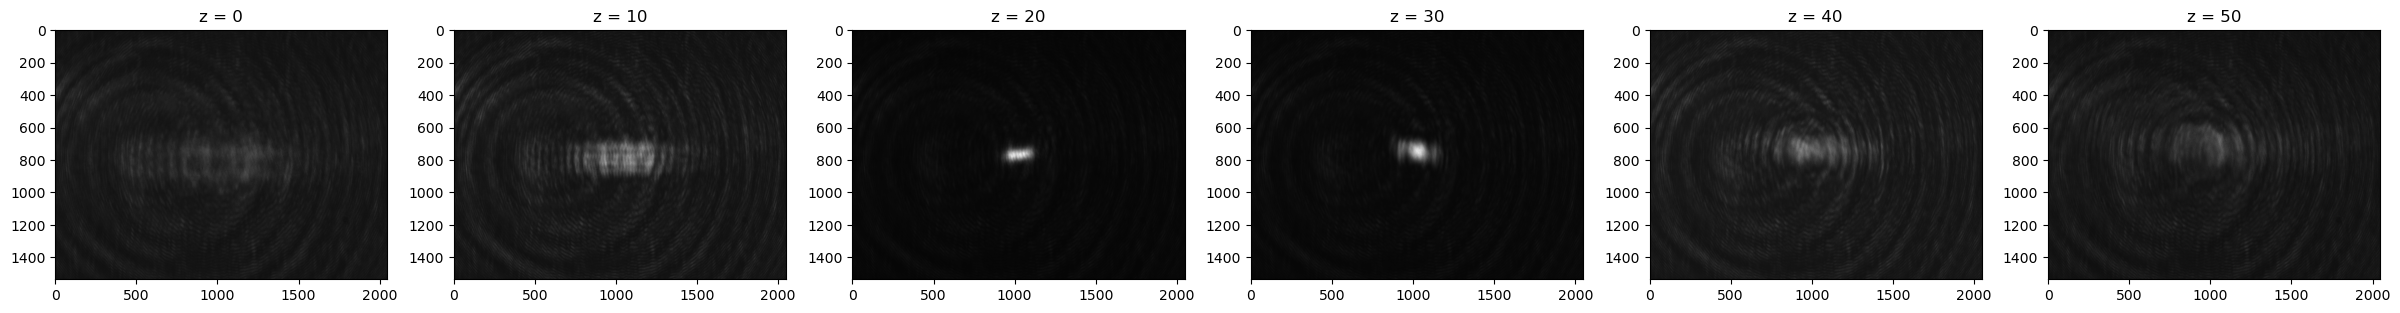

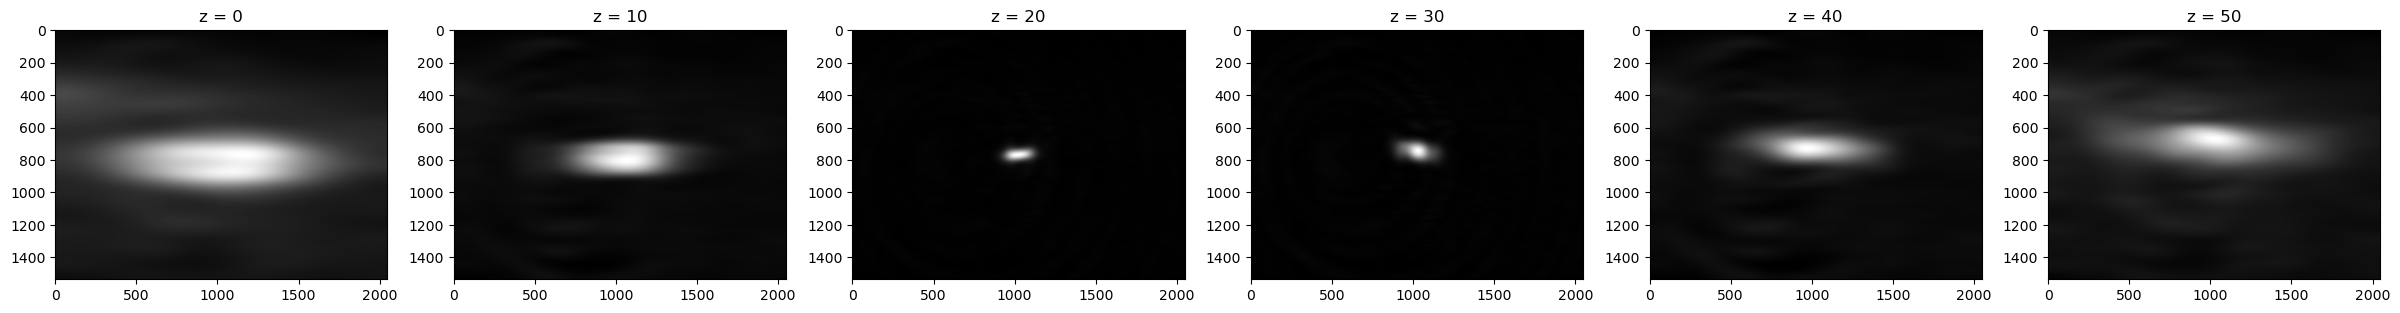

In [103]:
LDstack.filt_bgsub(kernel_scaling=0.25,aspect_ratio=5)#,kernel_size2=999,kernel_size1=1999,aspect_ratio=3)
frames = [0,10,20,30,40,50]
plotframes(LDstack.plainvol,frames) 
plotframes(LDstack.filtvol,frames) 

C:\Users\kumars2\AppData\Local\Temp\ipykernel_20088\2245079220.py:7: RuntimeWarning: divide by zero encountered in log
  im=plt.imshow(np.log(np.abs(file__),dtype='float32'),cmap='gray')
C:\Users\kumars2\AppData\Local\Temp\ipykernel_20088\2245079220.py:11: RuntimeWarning: divide by zero encountered in log
  im.set_array(np.log(np.abs(file_), dtype='float32'))


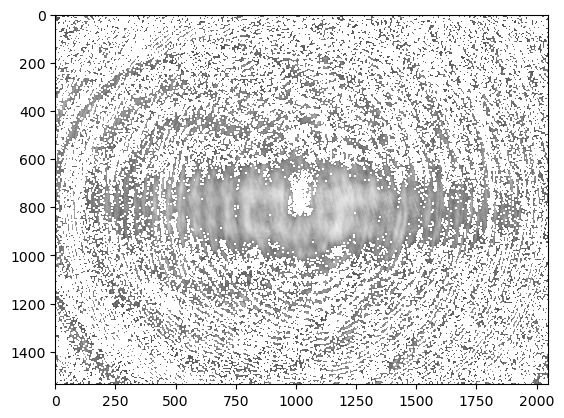

In [36]:
mp4_savefolder = "C:\\Temp\\Testdata\\AF\\2.5inch_LaserDiode\\20231023_2.5inch_50um_1um_2ms\\"
mp4_savename = "20231023_2.5inch_50um_1um_2ms_vid.mp4"
rawAnimation(LDstack.bgsubvol,mp4_savefolder,mp4_savename)

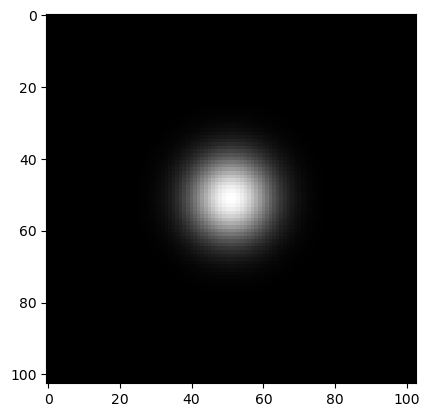

In [113]:
eval_kernel(50,50,2)

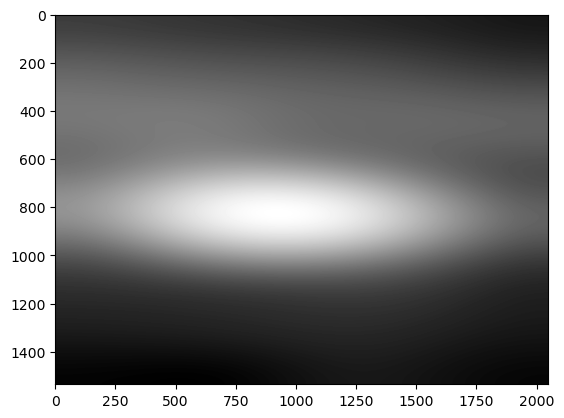

In [11]:
rawAnimation(LDstack.filtvol,'/Users/sh2717/Documents/AutoFocus_NNN/Data/openFrame/20231023_2inch_60um_1um_3ms/stack/','withoutlogabs_filt.mp4')

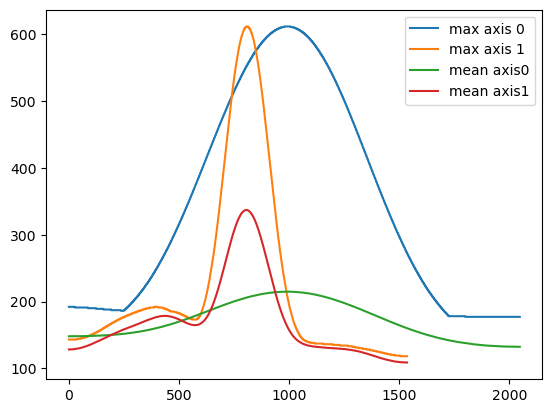

In [14]:
frame=10
plt.plot(LDstack.get_filt_bgsub_maxproj(frame,0),label='max axis 0')
plt.plot(LDstack.get_filt_bgsub_maxproj(frame,1),label='max axis 1')
plt.plot(LDstack.get_filt_bgsub_meanproj(frame,0),label='mean axis0')
plt.plot(LDstack.get_filt_bgsub_meanproj(frame,1),label='mean axis1')
plt.legend()

Processing metrics |████████████████████████████████████████| 51/51 [100%] in 3.


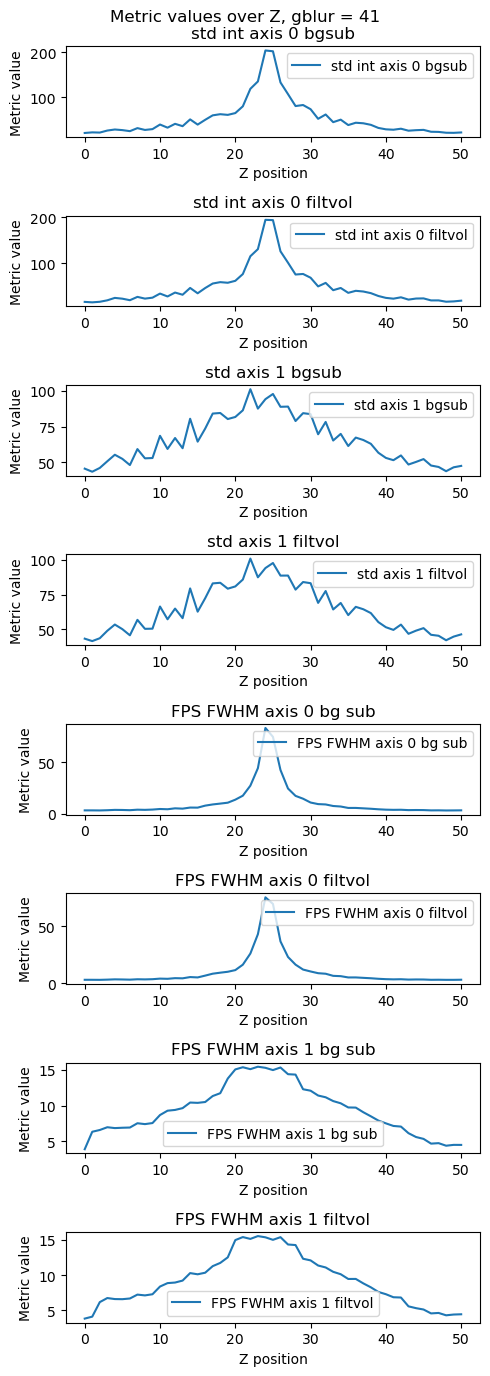

In [114]:
SG_w_x = 10 #5 #savolg kernel
SG_w_y=50
LDstack.gblur_applied=41
LDstack.s_gen_metrics(SG_w_x,SG_w_y,41)
LDstack.display_metrics()

2.2613726


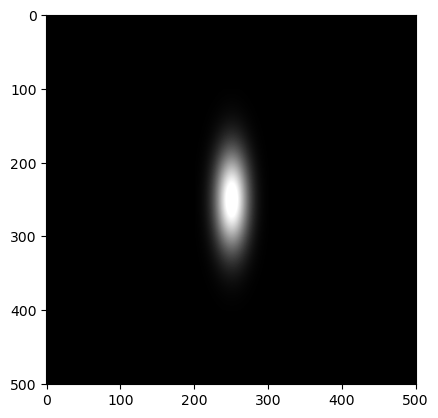

In [49]:
img=np.zeros((501,501))
img[251,251]=10000.0

img1=cv2.GaussianBlur(img, (101,301),0,0).astype(np.float32)
print(img1.max())
plt.imshow(img1,cmap='gray',vmin=0, vmax=2)